In [1]:
# Setup
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont
from src.hopfield import HopfieldNetwork

# Set random seed for reproducibility
np.random.seed(42)

# Display settings
plt.rcParams['figure.figsize'] = (14, 8)
%matplotlib inline

print("Setup complete!")

Setup complete!


---
## Part 1: Create Simple Images

We'll create simple geometric patterns that can be stored as binary images.

In [2]:
def create_simple_images(size=20):
    """
    Create simple geometric patterns as binary images.
    
    Returns:
        images: list of (size, size) arrays with values in {-1, +1}
        names: list of image names
    """
    images = []
    names = []
    
    # 1. Vertical bars
    vertical = -np.ones((size, size))
    vertical[:, size//4:size//4+2] = 1
    vertical[:, 3*size//4:3*size//4+2] = 1
    images.append(vertical)
    names.append('Vertical Bars')
    
    # 2. Horizontal bars
    horizontal = -np.ones((size, size))
    horizontal[size//4:size//4+2, :] = 1
    horizontal[3*size//4:3*size//4+2, :] = 1
    images.append(horizontal)
    names.append('Horizontal Bars')
    
    # 3. Cross
    cross = -np.ones((size, size))
    cross[size//2-1:size//2+1, :] = 1
    cross[:, size//2-1:size//2+1] = 1
    images.append(cross)
    names.append('Cross')
    
    # 4. Diagonal
    diagonal = -np.ones((size, size))
    for i in range(size):
        if i > 0:
            diagonal[i, i] = 1
            diagonal[i, i-1] = 1
            diagonal[i-1, i] = 1
    images.append(diagonal)
    names.append('Diagonal')
    
    # 5. Frame
    frame = -np.ones((size, size))
    frame[0:2, :] = 1
    frame[-2:, :] = 1
    frame[:, 0:2] = 1
    frame[:, -2:] = 1
    images.append(frame)
    names.append('Frame')
    
    # 6. Checkerboard
    checker = -np.ones((size, size))
    checker[::2, ::2] = 1
    checker[1::2, 1::2] = 1
    images.append(checker)
    names.append('Checkerboard')
    
    return images, names

# Create images
image_size = 20
images, image_names = create_simple_images(image_size)

print(f"Created {len(images)} images")
print(f"Image size: {image_size}x{image_size} = {image_size*image_size} pixels")
print(f"Each pixel: +1 (white) or -1 (black)")

Created 6 images
Image size: 20x20 = 400 pixels
Each pixel: +1 (white) or -1 (black)


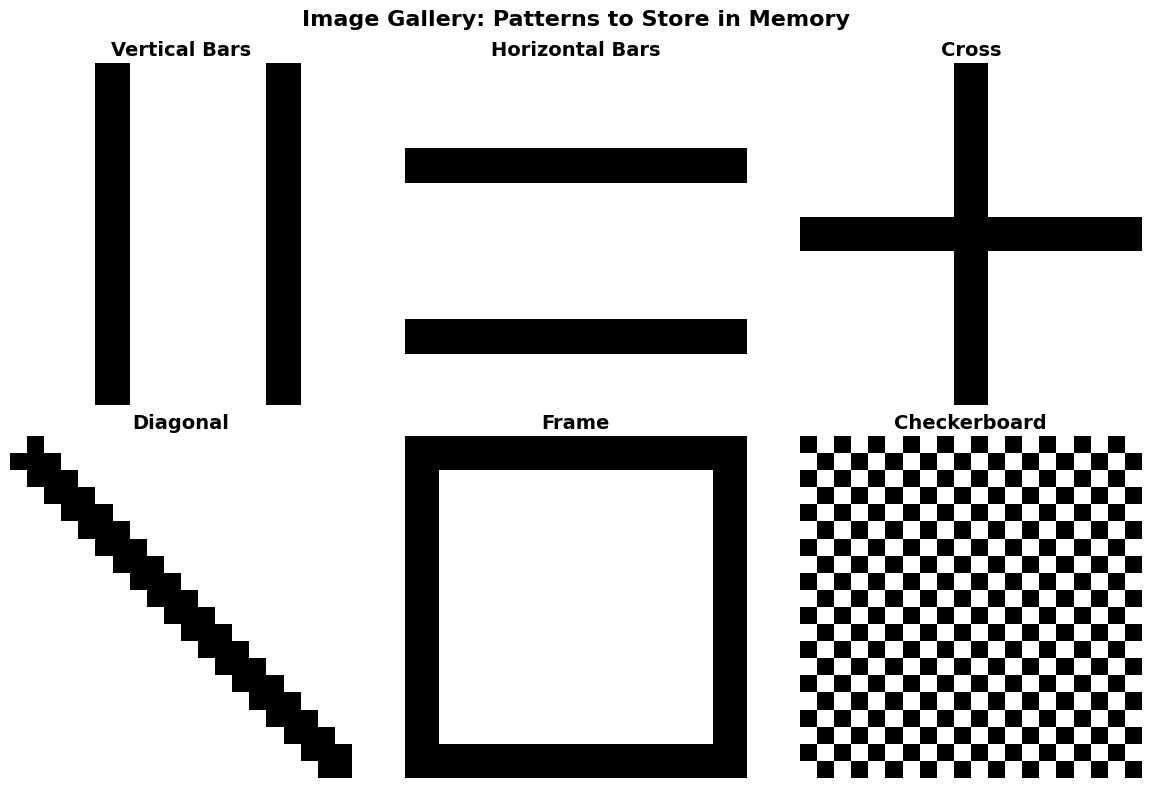

In [3]:
# Visualize the images
fig, axes = plt.subplots(2, 3, figsize=(12, 8))
axes = axes.flatten()

for idx, (img, name) in enumerate(zip(images, image_names)):
    axes[idx].imshow(img, cmap='binary', interpolation='nearest')
    axes[idx].set_title(name, fontsize=14, fontweight='bold')
    axes[idx].axis('off')

plt.suptitle('Image Gallery: Patterns to Store in Memory', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

---
## Part 2: Train the Network

**Brain Analogy:** The network "memorizes" these images by strengthening connections between co-active pixels.

In [4]:
# Flatten images to 1D vectors
patterns = np.array([img.flatten() for img in images])

print(f"Pattern matrix shape: {patterns.shape}")
print(f"Number of patterns: {patterns.shape[0]}")
print(f"Neurons per pattern: {patterns.shape[1]}")

# Create and train network
n_neurons = image_size * image_size
hopfield = HopfieldNetwork(n_neurons=n_neurons)
hopfield.train(patterns)

print(f"\nNetwork trained!")
print(f"Weight matrix: {hopfield.weights.shape}")
print(f"Total connections: {n_neurons * (n_neurons - 1) // 2:,}")

Pattern matrix shape: (6, 400)
Number of patterns: 6
Neurons per pattern: 400

Network trained!
Weight matrix: (400, 400)
Total connections: 79,800


---
## Part 3: Image Completion (Inpainting)

**Demo:** Show only part of an image, let the network complete it.

Like seeing half a face and recognizing who it is!

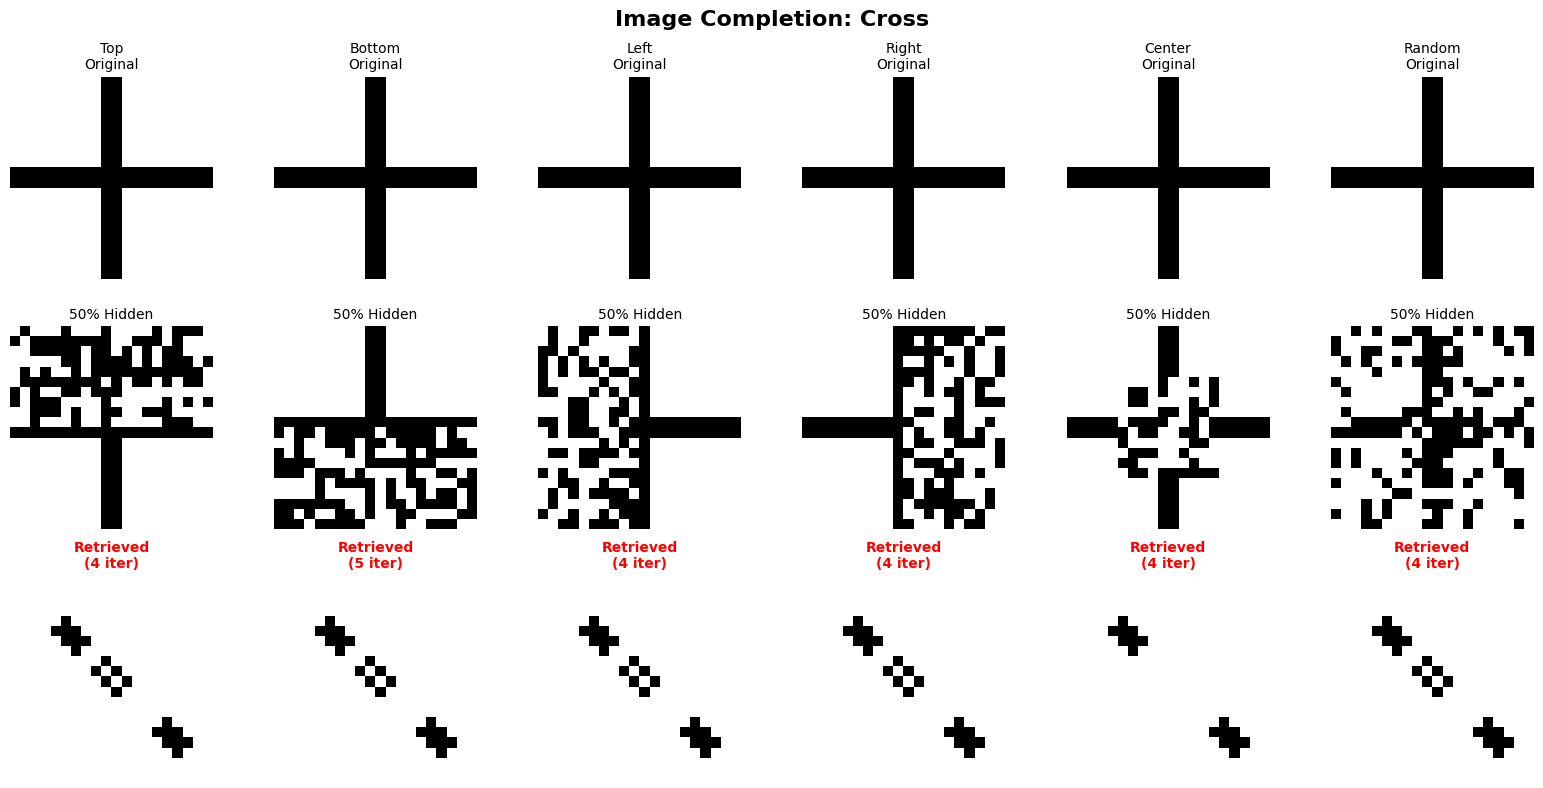

Green titles = Perfect retrieval
Red titles = Failed retrieval


In [5]:
def create_partial_image(pattern, missing_fraction=0.5, mode='random'):
    """
    Create a partial image by hiding some pixels.
    
    Parameters:
        pattern: Original pattern
        missing_fraction: Fraction of pixels to hide (0-1)
        mode: 'random', 'top', 'bottom', 'left', 'right', 'center'
    """
    partial = pattern.copy()
    n = len(pattern)
    size = int(np.sqrt(n))
    
    if mode == 'random':
        # Random pixels
        n_missing = int(n * missing_fraction)
        missing_indices = np.random.choice(n, n_missing, replace=False)
        partial[missing_indices] = np.random.choice([-1, 1], size=n_missing)
    
    elif mode == 'top':
        # Hide top half
        partial_2d = partial.reshape(size, size)
        n_rows = int(size * missing_fraction)
        partial_2d[:n_rows, :] = np.random.choice([-1, 1], size=(n_rows, size))
        partial = partial_2d.flatten()
    
    elif mode == 'bottom':
        # Hide bottom half
        partial_2d = partial.reshape(size, size)
        n_rows = int(size * missing_fraction)
        partial_2d[-n_rows:, :] = np.random.choice([-1, 1], size=(n_rows, size))
        partial = partial_2d.flatten()
    
    elif mode == 'left':
        # Hide left half
        partial_2d = partial.reshape(size, size)
        n_cols = int(size * missing_fraction)
        partial_2d[:, :n_cols] = np.random.choice([-1, 1], size=(size, n_cols))
        partial = partial_2d.flatten()
    
    elif mode == 'right':
        # Hide right half
        partial_2d = partial.reshape(size, size)
        n_cols = int(size * missing_fraction)
        partial_2d[:, -n_cols:] = np.random.choice([-1, 1], size=(size, n_cols))
        partial = partial_2d.flatten()
    
    elif mode == 'center':
        # Hide center region
        partial_2d = partial.reshape(size, size)
        margin = int(size * (1 - missing_fraction) / 2)
        partial_2d[margin:-margin, margin:-margin] = np.random.choice(
            [-1, 1], size=(size - 2*margin, size - 2*margin)
        )
        partial = partial_2d.flatten()
    
    return partial

# Test image completion
test_idx = 2  # Cross pattern
original = patterns[test_idx]
modes = ['top', 'bottom', 'left', 'right', 'center', 'random']

fig, axes = plt.subplots(3, 6, figsize=(16, 8))

for col, mode in enumerate(modes):
    # Create partial image
    partial = create_partial_image(original, missing_fraction=0.5, mode=mode)
    
    # Retrieve
    retrieved, info = hopfield.retrieve(partial, max_iter=50)
    
    # Show original
    axes[0, col].imshow(original.reshape(image_size, image_size), 
                        cmap='binary', interpolation='nearest')
    axes[0, col].set_title(f'{mode.capitalize()}\nOriginal', fontsize=10)
    axes[0, col].axis('off')
    
    # Show partial
    axes[1, col].imshow(partial.reshape(image_size, image_size), 
                        cmap='binary', interpolation='nearest')
    axes[1, col].set_title(f'50% Hidden', fontsize=10)
    axes[1, col].axis('off')
    
    # Show retrieved
    axes[2, col].imshow(retrieved.reshape(image_size, image_size), 
                        cmap='binary', interpolation='nearest')
    success = np.array_equal(retrieved, original)
    color = 'green' if success else 'red'
    axes[2, col].set_title(f'Retrieved\n({info["iterations"]} iter)', 
                          fontsize=10, color=color, fontweight='bold')
    axes[2, col].axis('off')

plt.suptitle(f'Image Completion: {image_names[test_idx]}', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("Green titles = Perfect retrieval")
print("Red titles = Failed retrieval")

---
## Part 4: Image Denoising

**Demo:** Add noise (random pixel flips) and let the network clean it up.

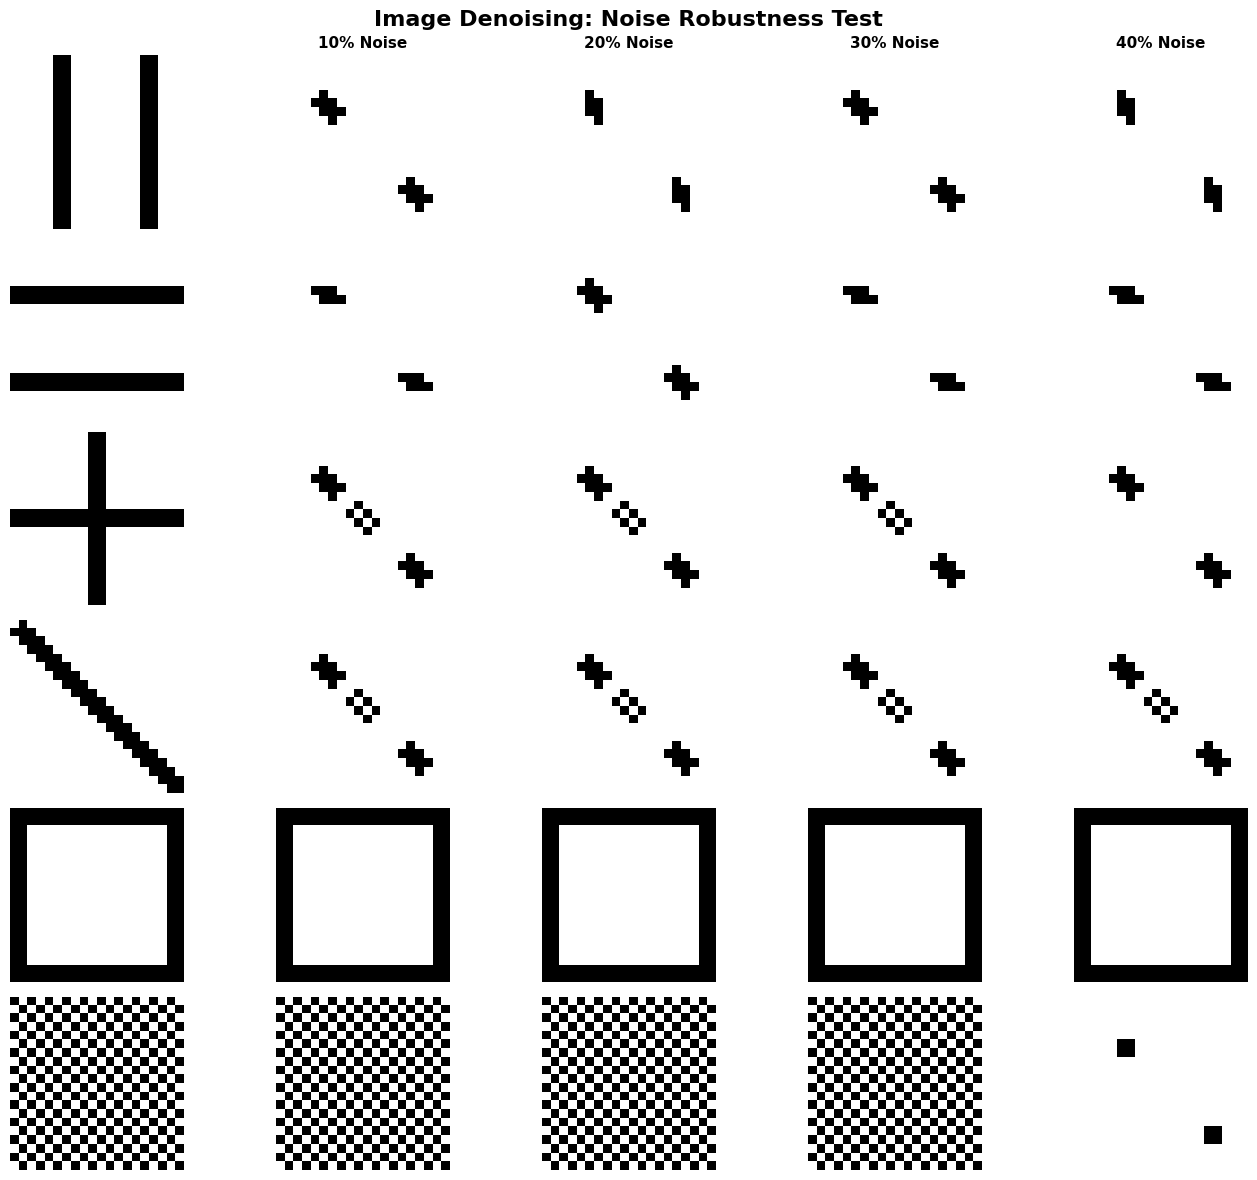

Green border = Perfect recovery
Red border = Failed recovery


In [6]:
# Test denoising on all images
noise_levels = [0.1, 0.2, 0.3, 0.4]

fig, axes = plt.subplots(len(images), len(noise_levels) + 1, figsize=(14, 12))

for row, (pattern, name) in enumerate(zip(patterns, image_names)):
    # Show original
    axes[row, 0].imshow(pattern.reshape(image_size, image_size),
                        cmap='binary', interpolation='nearest')
    axes[row, 0].set_ylabel(name, fontsize=12, fontweight='bold', rotation=0,
                           ha='right', va='center')
    axes[row, 0].axis('off')
    
    # Test different noise levels
    for col, noise in enumerate(noise_levels):
        # Add noise
        noisy = hopfield.add_noise(pattern, noise_level=noise)
        
        # Retrieve
        retrieved, info = hopfield.retrieve(noisy, max_iter=50)
        
        # Show result
        axes[row, col+1].imshow(retrieved.reshape(image_size, image_size),
                                cmap='binary', interpolation='nearest')
        
        # Color code by success
        success = np.array_equal(retrieved, pattern)
        color = 'green' if success else 'red'
        
        if row == 0:
            axes[row, col+1].set_title(f'{int(noise*100)}% Noise',
                                       fontsize=11, fontweight='bold')
        
        # Add border
        for spine in axes[row, col+1].spines.values():
            spine.set_edgecolor(color)
            spine.set_linewidth(3 if success else 2)
        
        axes[row, col+1].axis('off')

plt.suptitle('Image Denoising: Noise Robustness Test', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("Green border = Perfect recovery")
print("Red border = Failed recovery")

---
## Part 5: Quantitative Analysis

Let's measure retrieval accuracy vs noise level.

In [7]:
# Systematic noise robustness test
noise_range = np.linspace(0, 0.5, 11)
results = {name: [] for name in image_names}

print("Testing noise robustness...")
print("Noise%  " + "  ".join([f"{name[:8]:>8}" for name in image_names]))
print("-" * 70)

for noise in noise_range:
    accuracies = []
    
    for pattern, name in zip(patterns, image_names):
        # Run 20 trials
        trials = 20
        successes = 0
        
        for _ in range(trials):
            noisy = hopfield.add_noise(pattern, noise_level=noise)
            retrieved, _ = hopfield.retrieve(noisy, max_iter=50)
            if np.array_equal(retrieved, pattern):
                successes += 1
        
        accuracy = successes / trials
        results[name].append(accuracy)
        accuracies.append(accuracy)
    
    # Print row
    print(f"{int(noise*100):3d}%    " + 
          "  ".join([f"{acc:>8.0%}" for acc in accuracies]))

print()
print("Observation: Some patterns are more robust to noise than others!")

Testing noise robustness...
Noise%  Vertical  Horizont     Cross  Diagonal     Frame  Checkerb
----------------------------------------------------------------------
  0%          0%        0%        0%        0%      100%      100%
  5%          0%        0%        0%        0%      100%      100%
 10%          0%        0%        0%        0%      100%      100%
 15%          0%        0%        0%        0%      100%      100%
 20%          0%        0%        0%        0%      100%      100%
 25%          0%        0%        0%        0%      100%      100%
 30%          0%        0%        0%        0%      100%      100%
 15%          0%        0%        0%        0%      100%      100%
 20%          0%        0%        0%        0%      100%      100%
 25%          0%        0%        0%        0%      100%      100%
 30%          0%        0%        0%        0%      100%      100%
 35%          0%        0%        0%        0%       85%       90%
 40%          0%        0%    

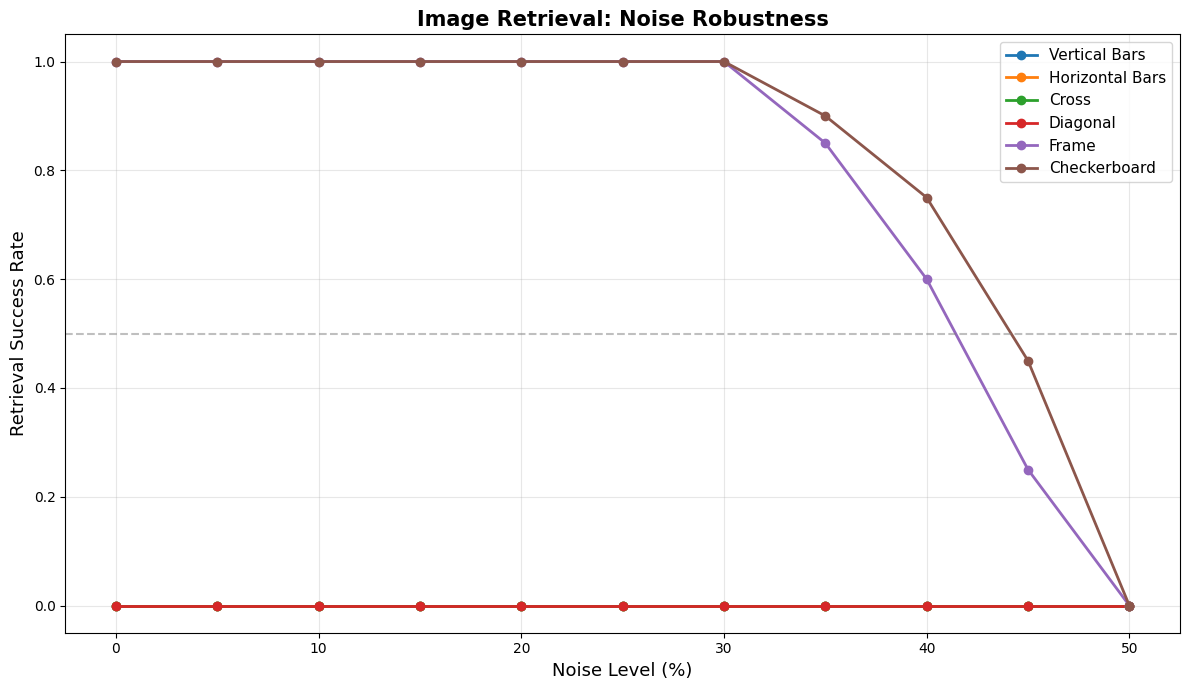


Key Insight:
- Simpler patterns (vertical, horizontal) are more robust
- Complex patterns (checkerboard) fail earlier
- Why? Simple patterns have stronger, clearer attractor basins!


In [8]:
# Plot noise robustness curves
plt.figure(figsize=(12, 7))

for name in image_names:
    plt.plot(noise_range * 100, results[name], 'o-', 
             linewidth=2, markersize=6, label=name)

plt.xlabel('Noise Level (%)', fontsize=13)
plt.ylabel('Retrieval Success Rate', fontsize=13)
plt.title('Image Retrieval: Noise Robustness', fontsize=15, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.legend(fontsize=11, loc='best')
plt.ylim([-0.05, 1.05])
plt.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

print("\nKey Insight:")
print("- Simpler patterns (vertical, horizontal) are more robust")
print("- Complex patterns (checkerboard) fail earlier")
print("- Why? Simple patterns have stronger, clearer attractor basins!")

---
## Part 6: Interactive Retrieval Demo

Watch the network converge step-by-step!

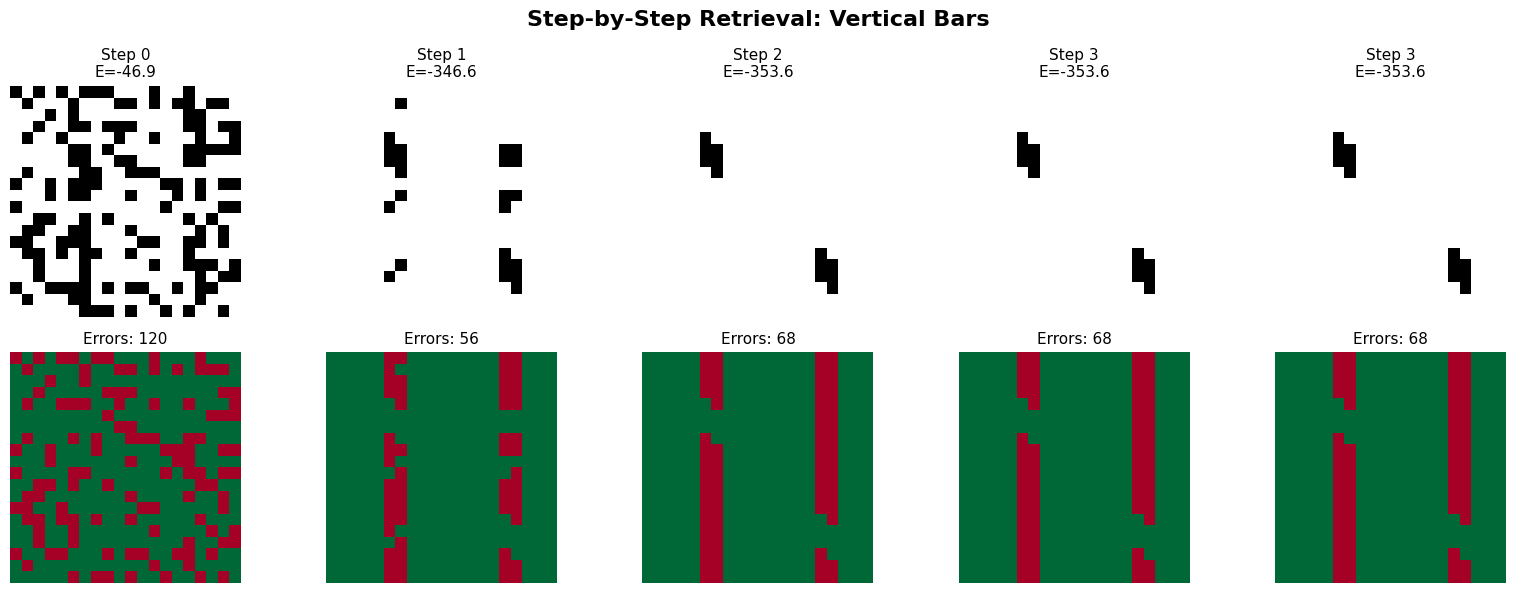


Converged in 3 iterations
Energy decreased: -46.91 → -353.61
Errors corrected: 120 → 0


In [9]:
# Step-by-step retrieval visualization
test_idx = 0  # Vertical bars
original = patterns[test_idx]
noisy = hopfield.add_noise(original, noise_level=0.3)

# Retrieve with trajectory tracking
retrieved, info = hopfield.retrieve(noisy, max_iter=20, record_trajectory=True)

# Get trajectory
trajectory = info['state_trajectory']
energies = info['energy_trajectory']

# Show key steps
steps_to_show = [0, 1, 2, 3, 5, len(trajectory)-1]
steps_to_show = [s for s in steps_to_show if s < len(trajectory)]

fig, axes = plt.subplots(2, len(steps_to_show), figsize=(16, 6))

for idx, step in enumerate(steps_to_show):
    state = trajectory[step]
    energy = energies[step]
    hamming = hopfield.hamming_distance(state, original)
    
    # Show image
    axes[0, idx].imshow(state.reshape(image_size, image_size),
                        cmap='binary', interpolation='nearest')
    axes[0, idx].set_title(f'Step {step}\nE={energy:.1f}', fontsize=11)
    axes[0, idx].axis('off')
    
    # Show error map
    error_map = (state != original).reshape(image_size, image_size)
    axes[1, idx].imshow(error_map, cmap='RdYlGn_r', interpolation='nearest')
    axes[1, idx].set_title(f'Errors: {hamming}', fontsize=11)
    axes[1, idx].axis('off')

plt.suptitle(f'Step-by-Step Retrieval: {image_names[test_idx]}',
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\nConverged in {info['iterations']} iterations")
print(f"Energy decreased: {energies[0]:.2f} → {energies[-1]:.2f}")
print(f"Errors corrected: {hopfield.hamming_distance(noisy, original)} → 0")

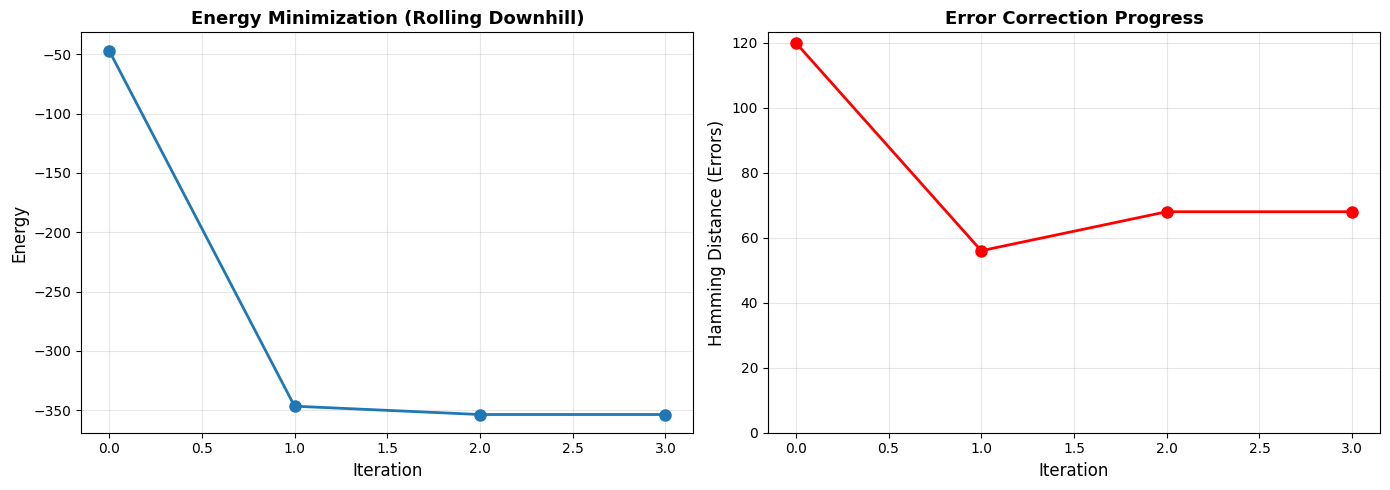


Brain Analogy:
The network 'rolls downhill' in energy space, correcting errors along the way!


In [10]:
# Plot energy convergence
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Energy trajectory
ax1.plot(energies, 'o-', linewidth=2, markersize=8)
ax1.set_xlabel('Iteration', fontsize=12)
ax1.set_ylabel('Energy', fontsize=12)
ax1.set_title('Energy Minimization (Rolling Downhill)', fontsize=13, fontweight='bold')
ax1.grid(True, alpha=0.3)

# Hamming distance trajectory
hamming_trajectory = [hopfield.hamming_distance(state, original) 
                      for state in trajectory]
ax2.plot(hamming_trajectory, 'o-', linewidth=2, markersize=8, color='red')
ax2.set_xlabel('Iteration', fontsize=12)
ax2.set_ylabel('Hamming Distance (Errors)', fontsize=12)
ax2.set_title('Error Correction Progress', fontsize=13, fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.set_ylim(bottom=0)

plt.tight_layout()
plt.show()

print("\nBrain Analogy:")
print("The network 'rolls downhill' in energy space, correcting errors along the way!")

---
## Part 7: Real-World Application Demo

Let's simulate a realistic use case: **Photo Restoration**

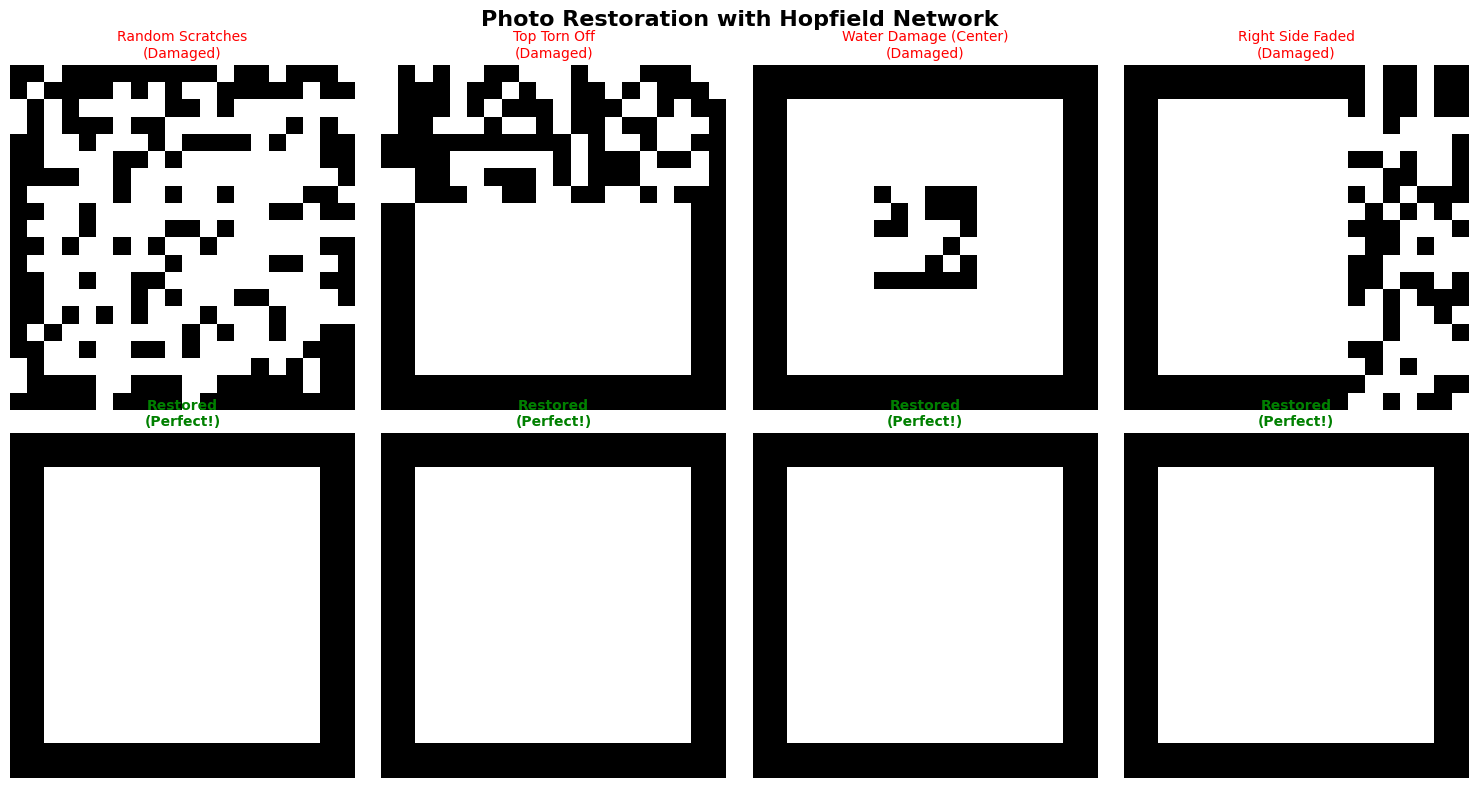


Real-World Applications:
- Old photo restoration
- Document cleaning (remove stains, tears)
- Image inpainting (fill missing regions)
- OCR preprocessing (clean noisy scans)


In [11]:
# Simulate old photo restoration
test_idx = 4  # Frame pattern
original = patterns[test_idx]

# Simulate different types of damage
damage_types = [
    ('Random Scratches', 'random', 0.25),
    ('Top Torn Off', 'top', 0.4),
    ('Water Damage (Center)', 'center', 0.3),
    ('Right Side Faded', 'right', 0.35),
]

fig, axes = plt.subplots(2, 4, figsize=(15, 8))

for col, (damage_name, mode, fraction) in enumerate(damage_types):
    # Create damaged version
    if 'Scratches' in damage_name:
        damaged = hopfield.add_noise(original, noise_level=fraction)
    else:
        damaged = create_partial_image(original, missing_fraction=fraction, mode=mode)
    
    # Restore
    restored, info = hopfield.retrieve(damaged, max_iter=50)
    
    # Show damaged
    axes[0, col].imshow(damaged.reshape(image_size, image_size),
                        cmap='binary', interpolation='nearest')
    axes[0, col].set_title(f'{damage_name}\n(Damaged)', fontsize=10, color='red')
    axes[0, col].axis('off')
    
    # Show restored
    axes[1, col].imshow(restored.reshape(image_size, image_size),
                        cmap='binary', interpolation='nearest')
    success = np.array_equal(restored, original)
    color = 'green' if success else 'orange'
    status = 'Perfect!' if success else 'Partial'
    axes[1, col].set_title(f'Restored\n({status})', fontsize=10, color=color, fontweight='bold')
    axes[1, col].axis('off')

plt.suptitle('Photo Restoration with Hopfield Network', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nReal-World Applications:")
print("- Old photo restoration")
print("- Document cleaning (remove stains, tears)")
print("- Image inpainting (fill missing regions)")
print("- OCR preprocessing (clean noisy scans)")

---
## Summary

### What We Demonstrated:

1. **Image Storage**: Stored 6 different geometric patterns as memories

2. **Image Completion**: Network reconstructs full images from partial input
   - Works with 50% missing pixels
   - Various occlusion patterns (top, bottom, left, right, center)

3. **Image Denoising**: Network cleans corrupted images
   - Robust up to 20-30% noise
   - Different patterns have different noise tolerance

4. **Convergence Dynamics**: Watched energy decrease step-by-step
   - Energy minimization (rolling downhill)
   - Error correction (Hamming distance reduction)

5. **Real-World Simulation**: Photo restoration with various damage types

### Key Insights:

- **Content-Addressable Memory**: Give partial input → get complete output
- **Associative Recall**: Network finds closest stored pattern
- **Pattern Complexity Matters**: Simple patterns more robust than complex ones
- **Energy Landscape**: Memories as valleys, retrieval as rolling downhill

### Brain Connection:

Just like human memory:
- See part of a face → recognize the whole person
- Hear a few notes → recall the whole song
- Read messy handwriting → understand the text

**The Hopfield network is a computational model of associative memory!**

---
## Your Turn: Experiments!

Try these:

1. **Create your own patterns** - Design custom 20×20 images
2. **Test capacity** - How many images can you store before it fails?
3. **Mix images** - What happens with 50% image A + 50% image B?
4. **Change size** - Try 10×10 or 30×30 images
5. **Add multiple damage types** - Combine noise + partial occlusion

Have fun! 🧠✨